# Insights of Oil & Gas Companies

This is Part 1 of my project **for stock data analysis**.
I just focus on 5 years’ historical stock price data of the four companies
(OXY, EOG, COP and PXD) from Yahoo by pandas-datareader.

I perform data analysis in the following aspects:
1. Summarize the data with descriptive stats
2. Candlestick plot visualization of stock data
3. Plot the 'Close' trend and 'Volume'
4. Compare and calculate correlations between companies 
5. Calculate and visualize returns

In [83]:
# Load packages
import pandas as pd
import numpy as np
from pandas_datareader.data import DataReader
from datetime import date

#visualizations
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import style
style.use('ggplot')
from mpl_finance import candlestick_ohlc
from matplotlib.dates import date2num
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 10
import seaborn as sns
sns.set(context='paper',style='whitegrid',font_scale=2, rc={"lines.linewidth": 2.5})

import os 
import glob 

#web scraping
import requests
from bs4 import BeautifulSoup
from lxml import html

import warnings
warnings.filterwarnings('ignore')

### load the stock data from yahoo in the past five years.

In [6]:
start=date(2015,1,1)
end=date.today()
tickers=['OXY', 'EOG','COP','PXD']
data_source='yahoo'

In [7]:
def get_data_from_yahoo():
    if not os.path.exists('data_stocks'):
        os.makedirs('data_stocks')
   
    for ticker in tickers:
        if not os.path.exists('data_stocks/{}.csv'.format(ticker)):
            df=DataReader(ticker,data_source,start,end)
            df.to_csv('data_stocks/{}.csv'.format(ticker))
        else:
            print('Already have {}'.format(ticker))
get_data_from_yahoo()

os.listdir('data_stocks')

['OXY.csv', 'EOG.csv', 'COP.csv', 'PXD.csv']

In [8]:
fp=glob.glob('data_stocks/*.csv')
oxy, eog, cop, pxd=[pd.read_csv(f,parse_dates=True,index_col=0) for f in fp]

### Stock trend
The code below takes 'OXY' company as an example but can be easily implemented on other companies.

In [12]:
oxy.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-02,80.962128,79.145226,79.873985,80.512894,3640700.0,63.451164
2015-01-05,79.245056,76.779251,79.245056,77.527977,6115000.0,61.098808
2015-01-06,78.097008,75.930695,76.938980,76.869102,6048300.0,60.579556
2015-01-07,78.146927,75.870796,77.807503,76.879082,5484600.0,60.587410
2015-01-08,78.626106,77.348282,77.677727,77.557930,6746100.0,61.122406


In [13]:
oxy.describe()

,High,Low,Open,Close,Volume,Adj Close
count,1276.000000,1276.000000,1276.000000,1276.000000,1.276000e+03,1276.000000
mean,67.918604,66.536514,67.266207,67.236980,5.622409e+06,58.698863
std,11.111339,11.006779,11.063766,11.070759,3.166914e+06,8.487121
min,37.970001,37.250000,37.509998,37.340000,1.319200e+06,36.995312
25%,63.102499,61.797500,62.387500,62.497500,3.744800e+06,54.185850
50%,69.506638,67.924999,68.750000,68.668064,4.769550e+06,59.331928
75%,75.842501,74.560001,75.124573,75.250463,6.425025e+06,63.043618
max,87.669998,86.169998,87.000000,86.480003,3.667860e+07,78.917694


#### 5 year stock price distribution

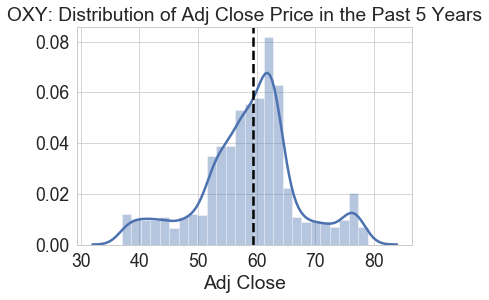

In [18]:
ax=sns.distplot(oxy['Adj Close'])
ax.axvline(oxy['Adj Close'].median(),color='black',ls='--')
ax.set_title('OXY: Distribution of Adj Close Price in the Past 5 Years');

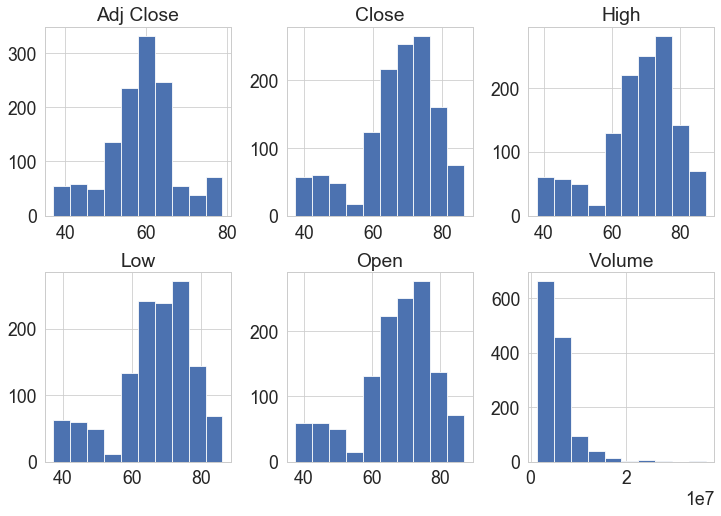

In [15]:
oxy.hist(layout=(2,3), figsize=(12,8));

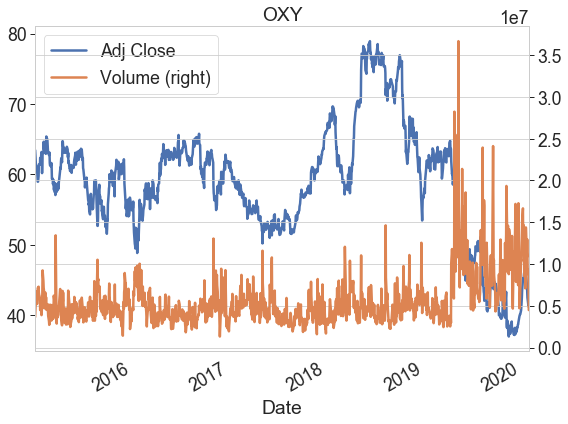

In [23]:
data=oxy.loc[:,['Adj Close','Volume']]
data.plot(title='OXY',secondary_y='Volume', figsize=(8,6))
plt.tight_layout();

### Smooth the curve by calculating the rolling mean

In [24]:
oxy['100movavg']=oxy['Adj Close'].rolling(window=100,min_periods=0).mean()
oxy['100movavgV']=oxy['Volume'].rolling(window=100,min_periods=0).mean()

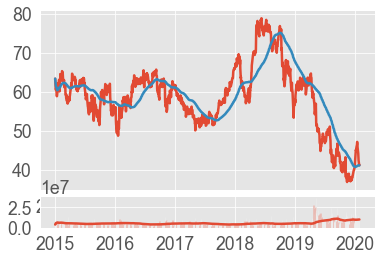

In [26]:
style.use('ggplot')
ax1=plt.subplot2grid((6,1),(0,0),rowspan=5,colspan=1)
ax2=plt.subplot2grid((6,1),(5,0),rowspan=1,colspan=1,sharex=ax1)


ax1.plot(oxy.index,oxy['Adj Close'])
ax1.plot(oxy.index,oxy['100movavg'])
ax2.bar(oxy.index,oxy['Volume'])
ax2.plot(oxy.index,oxy['100movavgV'])

plt.show()

### Resample daily data to reduce data size and add candlestick visuals

In [27]:
df_ohlc=oxy['Adj Close'].resample('10D').ohlc()
df_volume=oxy['Volume'].resample('10D').sum()

df_ohlc.reset_index(inplace=True)
df_ohlc['Date']=df_ohlc['Date'].map(date2num)

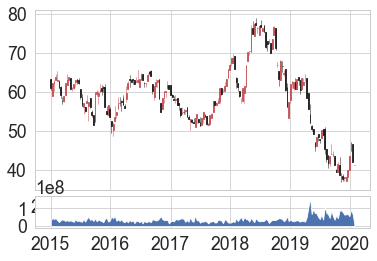

In [33]:
sns.set(context='paper',style='whitegrid',font_scale=2, rc={"lines.linewidth": 2.5})
ax1=plt.subplot2grid((6,1),(0,0),rowspan=5,colspan=1)
ax2=plt.subplot2grid((6,1),(5,0),rowspan=1,colspan=1,sharex=ax1)
ax1.xaxis_date()

candlestick_ohlc(ax1,df_ohlc.values,width=5,colorup='r',colordown='k',alpha=1.)

ax2.fill_between(df_volume.index.map(date2num),df_volume.values,0);

### Calculate correlations

In [34]:
#Define a function to join 'Adj Close' of all the companies of interest
def join_data():
    df_join=pd.DataFrame()
    
    for count,ticker in enumerate(tickers):
        df=pd.read_csv('data_stocks/{}.csv'.format(ticker))
        df.set_index('Date',inplace=True)
        
        df.rename(columns={'Adj Close':ticker},inplace=True)
        df.drop(['Open','High','Low','Close','Volume'],1,inplace=True)
        
        if df_join.empty:
            df_join=df
        else:
            df_join=df_join.join(df, how='outer')
        
    df_join.to_csv('tickers_joined_adjcloses.csv')
    
join_data()
df_j=pd.read_csv('tickers_joined_adjcloses.csv',parse_dates=True,index_col=0)

In [35]:
df_j=pd.read_csv('tickers_joined_adjcloses.csv',parse_dates=True,index_col=0)
df_j.head()

,OXY,EOG,COP,PXD
Date,,,,
2015-01-02,63.451164,88.220093,60.137852,148.109772
2015-01-05,61.098808,82.902397,57.275810,138.169266
2015-01-06,60.579556,80.540054,54.911129,137.803680
2015-01-07,60.587410,80.033127,55.277618,136.291824
2015-01-08,61.122406,83.093674,56.656281,139.730515


In [36]:
df_j.isnull().sum()

OXY    0
EOG    0
COP    0
PXD    0
dtype: int64

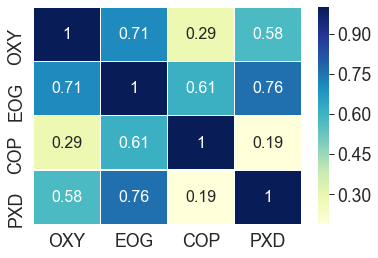

In [37]:
corr=df_j.corr()
sns.heatmap(corr,annot=True,linewidths=0.4,annot_kws={'size':16},cmap="YlGnBu");

As shown in the heatmap, some companies are highly correlated.

### visualize the 'Adj Close' on a monthly basis in the past 5 years

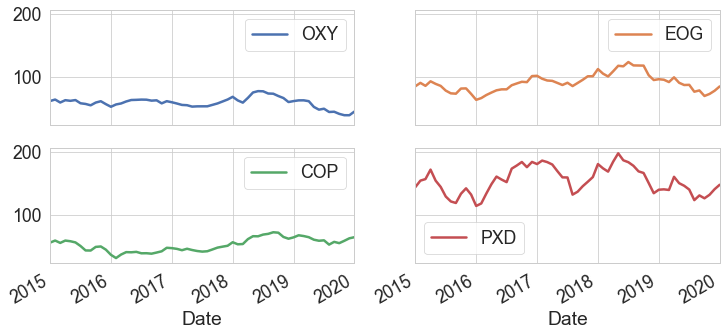

In [39]:
monthly_adjc=df_j.resample('MS').mean()
monthly_adjc.plot(subplots=True,layout=(3,2),sharey=True, figsize=(12,8));

### Calculate returns


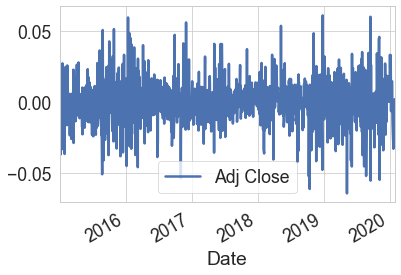

In [40]:
daily_close = oxy[['Adj Close']]
daily_pct_c = daily_close.pct_change()
daily_pct_c.fillna(0, inplace=True)

daily_pct_c.plot();

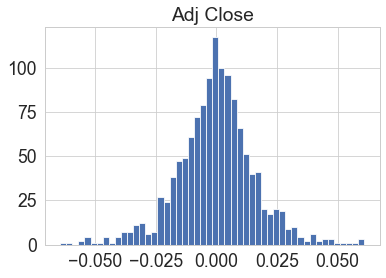

In [41]:
#Daily returns alternatively
daily_pct_c = daily_close / daily_close.shift(1) - 1
daily_pct_c.hist(bins=50);

The distribution looks very symmetrical and normally distributed: the daily changes center around the bin 0.00.

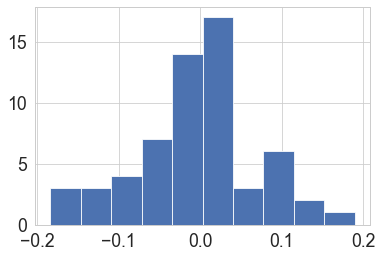

In [42]:
# Resample to business months, take last observation as value 
monthly = oxy['Adj Close'].resample('BM').apply(lambda x: x[-1])

# Calculate the monthly percentage change
monthly.pct_change().hist(bins=10);

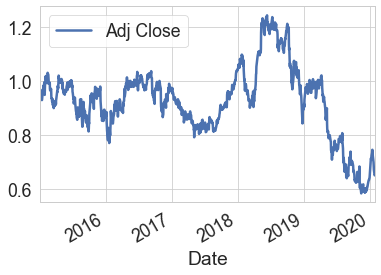

In [43]:
#calcualte cumulative daily returns
cum_daily_return = (1 + daily_pct_c).cumprod()#cumprod() return cumulative product

cum_daily_return.plot();

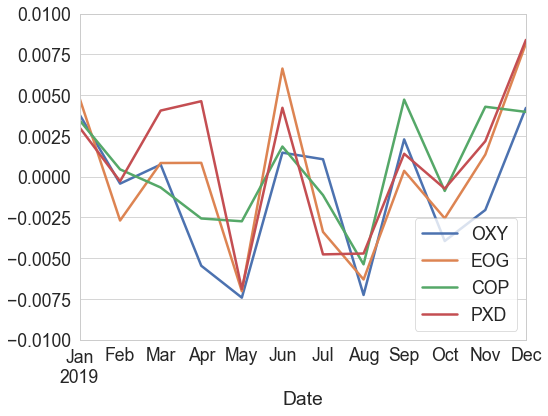

In [48]:
#Display the returns in 2019
year19=df_j[df_j.index.year==2019]
year19.pct_change().resample('BM').mean().plot(figsize=(8,6))
plt.ylim(-0.01,0.01);

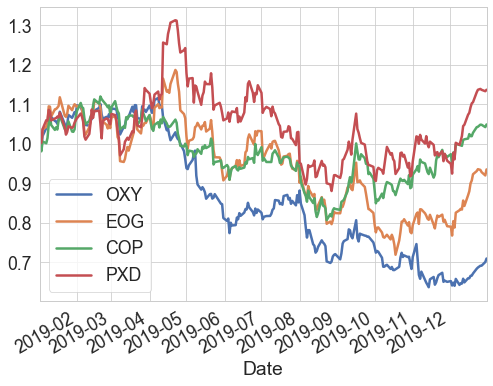

In [50]:
#Trend compared with start of perid: year19.index[0]
(year19/year19.iloc[0,:]).plot(figsize=(8,6));

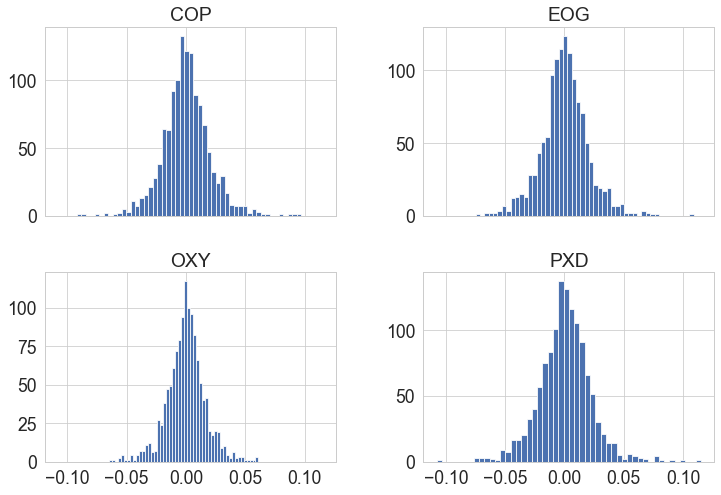

In [51]:
daily_pct_change=df_j.pct_change()
daily_pct_change.hist(bins=50,sharex=True,figsize=(12,8));